In [1]:
!pip install segmentation-models-pytorch -q
!pip install timm -q

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
ROOT = Path("/kaggle/input/dataset-zip/anomaly_detection_test_data")

GOOD = ROOT / "good"
BAD  = ROOT / "bad"
MASK = ROOT / "masks"

good_imgs = sorted(GOOD.glob("*"))
bad_imgs  = sorted(BAD.glob("*"))
mask_imgs = sorted(MASK.glob("*"))

print("Total good images :", len(good_imgs))
print("Total bad images  :", len(bad_imgs))
print("Total mask images :", len(mask_imgs))


Total good images : 4157
Total bad images  : 1023
Total mask images : 1023


In [3]:
# Masks match bad filenames exactly
bad_masks = [MASK / b.name for b in bad_imgs]

missing = [m for m in bad_masks if not m.exists()]
print("Missing masks:", missing[:5] if missing else "None")

# Bad split
b_train, b_test, m_train, m_test = train_test_split(
    bad_imgs, bad_masks, test_size=0.10, random_state=42
)
b_train, b_val, m_train, m_val = train_test_split(
    b_train, m_train, test_size=0.10, random_state=42
)

# Good split
g_train, g_test = train_test_split(good_imgs, test_size=0.10, random_state=42)
g_train, g_val  = train_test_split(g_train, test_size=0.10, random_state=42)

# Merge
train_imgs  = list(b_train) + list(g_train)
train_masks = list(m_train) + [None]*len(g_train)

val_imgs  = list(b_val) + list(g_val)
val_masks = list(m_val) + [None]*len(g_val)

test_imgs  = list(b_test) + list(g_test)
test_masks = list(m_test) + [None]*len(g_test)

print("Train:", len(train_imgs))
print("Val  :", len(val_imgs))
print("Test :", len(test_imgs))


Missing masks: None
Train: 4194
Val  : 467
Test : 519


In [4]:
def pad_to_square(img, fill=0):
    """Pad image/mask to square without distortion."""
    w, h = img.size
    if w == h:
        return img
    s = max(w, h)
    new_img = Image.new(img.mode, (s, s), fill)
    new_img.paste(img, ((s - w)//2, (s - h)//2))
    return new_img


In [5]:
IMAGE_SIZE = (512, 512)

train_t = T.Compose([
    T.RandomHorizontalFlip(p=0.5),     #
    T.RandomRotation(degrees=3),       
    T.ColorJitter(
        brightness=0.20,
        contrast=0.20,
        saturation=0.15,
        hue=0.03,
    ),
    T.ToTensor(),                      #
])

val_t = T.Compose([
    T.ToTensor(),
])


In [6]:
class ScratchDataset(Dataset):
    def __init__(self, imgs, masks, transform=None, image_size=(384,384)):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")

        mask_path = self.masks[idx]
        if mask_path is None:
            mask = Image.new("L", img.size, 0)
        else:
            mask = Image.open(mask_path).convert("L")

        # 1. Pad
        img = pad_to_square(img)
        mask = pad_to_square(mask)

        # 2. Resize
        img = img.resize(self.image_size)
        mask = mask.resize(self.image_size, Image.NEAREST)

        # 3. Augment image only
        if self.transform is not None:
            img = self.transform(img)

        # 4. Mask to tensor
        mask = torch.tensor(np.array(mask)/255.0, dtype=torch.float32).unsqueeze(0)

        return img.float(), mask.float()


In [7]:
train_ds = ScratchDataset(train_imgs, train_masks, train_t, IMAGE_SIZE)
val_ds   = ScratchDataset(val_imgs, val_masks, val_t, IMAGE_SIZE)
test_ds  = ScratchDataset(test_imgs, test_masks, val_t, IMAGE_SIZE)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=2)

print("Loaders ready")


Loaders ready


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="efficientnet-b5",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

In [9]:
bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    inter = (pred*target).sum((2,3))
    union = pred.sum((2,3)) + target.sum((2,3))
    return 1 - ((2*inter+smooth) / (union+smooth)).mean()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=2)


In [10]:
def train_epoch(loader):
    model.train()
    total = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)

        logits = model(imgs)
        loss = bce(logits, masks) + dice_loss(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item() * imgs.size(0)
    return total / len(loader.dataset)


@torch.no_grad()
def val_epoch(loader):
    model.eval()
    total = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        loss = bce(logits, masks) + dice_loss(logits, masks)
        total += loss.item() * imgs.size(0)
    return total / len(loader.dataset)


In [11]:
best = 999
EPOCHS = 25

for ep in range(1, EPOCHS+1):
    tr = train_epoch(train_loader)
    vl = val_epoch(val_loader)
    scheduler.step(vl)

    print(f"Epoch {ep}/{EPOCHS} | Train={tr:.4f} | Val={vl:.4f}")

    if vl < best:
        best = vl
        torch.save(model.state_dict(), "best_segmentation_b5_512*512.pth")
        print("✓ Saved best model")


Epoch 1/25 | Train=1.1051 | Val=0.9874
✓ Saved best model
Epoch 2/25 | Train=0.9693 | Val=0.8930
✓ Saved best model
Epoch 3/25 | Train=0.9420 | Val=0.8768
✓ Saved best model
Epoch 4/25 | Train=0.9277 | Val=0.8654
✓ Saved best model
Epoch 5/25 | Train=0.9293 | Val=0.8637
✓ Saved best model
Epoch 6/25 | Train=0.6418 | Val=0.3651
✓ Saved best model
Epoch 7/25 | Train=0.2610 | Val=0.1947
✓ Saved best model
Epoch 8/25 | Train=0.2354 | Val=0.1180
✓ Saved best model
Epoch 9/25 | Train=0.2175 | Val=0.1064
✓ Saved best model
Epoch 10/25 | Train=0.1726 | Val=0.0874
✓ Saved best model
Epoch 11/25 | Train=0.1569 | Val=0.0943
Epoch 12/25 | Train=0.1590 | Val=0.0689
✓ Saved best model
Epoch 13/25 | Train=0.1458 | Val=0.0756
Epoch 14/25 | Train=0.1397 | Val=0.0683
✓ Saved best model
Epoch 15/25 | Train=0.1314 | Val=0.0671
✓ Saved best model
Epoch 16/25 | Train=0.1288 | Val=0.0660
✓ Saved best model
Epoch 17/25 | Train=0.1339 | Val=0.0686
Epoch 18/25 | Train=0.1294 | Val=0.0623
✓ Saved best model
Epoc

In [12]:
model.load_state_dict(torch.load("best_segmentation_b5_512*512.pth"))
model.eval()

def evaluate(loader):
    TP = FP = FN = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            preds = (torch.sigmoid(logits) > 0.5).float()

            p = preds.cpu().numpy().reshape(-1)
            g = masks.cpu().numpy().reshape(-1)

            TP += np.sum((p==1)&(g==1))
            FP += np.sum((p==1)&(g==0))
            FN += np.sum((p==0)&(g==1))

    precision = TP / (TP+FP+1e-6)
    recall    = TP / (TP+FN+1e-6)
    return precision, recall

prec, rec = evaluate(test_loader)
print("Segmentation Precision:", prec)
print("Segmentation Recall   :", rec)


Segmentation Precision: 0.7864474461041614
Segmentation Recall   : 0.7445685118133201


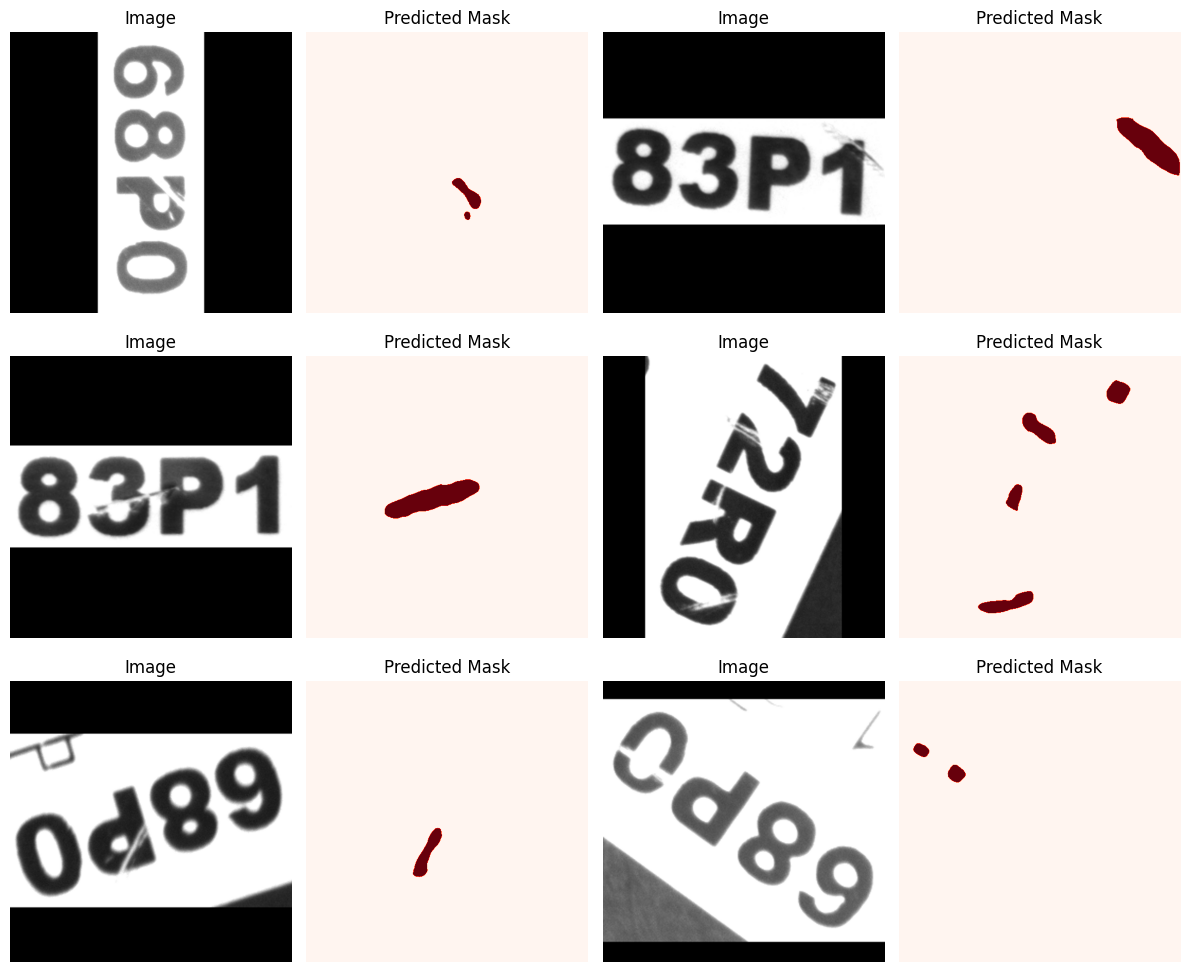

In [13]:
def show_predictions():
    model.eval()
    imgs, masks = next(iter(test_loader))
    imgs = imgs.to(device)

    with torch.no_grad():
        preds = torch.sigmoid(model(imgs)) > 0.5

    plt.figure(figsize=(12, 10))
    for i in range(6):
        img = imgs[i].cpu().permute(1,2,0).numpy()
        pred = preds[i][0].cpu().numpy()

        plt.subplot(3, 4, 2*i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Image")

        plt.subplot(3, 4, 2*i+2)
        plt.imshow(pred, cmap="Reds")
        plt.axis("off")
        plt.title("Predicted Mask")

    plt.tight_layout()
    plt.show()

show_predictions()
